In [15]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
#from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D, Dropout
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from tensorflow.keras.applications.resnet50 import preprocess_input
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import scipy
import random
import gc
import glob
from keras.utils.vis_utils import plot_model


In [16]:
#Read in CSV file for FER2013 data to be manipulated.
data = pd.read_csv('/com.docker.devenvironments.code/fer2013/icml_face_data.csv')

In [17]:
#Define which CSV data is image data and which is label data.
pixel_data = data[' pixels']
label_data = data['emotion']

In [18]:
#Print number of images that can be generated from CSV data. 
len(label_data)

35887

In [19]:
#Pre-process the CSV data and reshape it into a 48x48 image.
def preprocess_pixels(pixel_data):
  images = []
  for i in range(len(pixel_data)):
    img = np.fromstring(pixel_data[i], dtype='int', sep=' ')
    img = img.reshape(48,48,1)
    images.append(img)

  X = np.array(images)
  return X



In [20]:
#Duplicate data for emotion classes with lower samples, 'auto' means all will have the same number of examples.

oversampler = RandomOverSampler(sampling_strategy='auto')

X_over, Y_over = oversampler.fit_resample(pixel_data.values.reshape(-1,1), label_data)

In [21]:
#Test that the reshaped data fits a 48x48 image.
X_over_series = pd.Series(X_over.flatten())
X_over_series

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    162 163 165 166 114 72 79 115 153 174 204 205 ...
62919    253 252 252 250 249 253 252 244 229 208 149 93...
62920    50 9 10 6 5 5 5 5 5 4 7 7 13 25 29 37 53 64 69...
62921    66 70 58 12 11 27 31 27 38 53 29 9 15 9 10 13 ...
62922    10 10 14 18 10 13 20 18 18 19 16 14 19 14 14 1...
Length: 62923, dtype: object

In [22]:
#Preprocess data and turn into image form.
X = preprocess_pixels(X_over_series)
Y = Y_over

In [23]:
Y = Y_over.values.reshape(Y.shape[0],1)
Y.shape

(62923, 1)

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 45)
print(X_train.shape, Y_train.shape)

(56630, 48, 48, 1) (56630, 1)


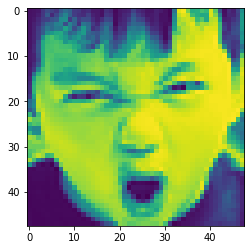

In [25]:
#Test random image from dataset and display it to check that it has formed an image.
plt.imshow(X[25000,:,:,0])

In [26]:
#Define the model.
def emotion_recognition(input_shape):

  X_input = Input(input_shape)

  X = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid')(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)


  X = Conv2D(64, (3,3), strides=(1,1), padding = 'same')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64, (3,3), strides=(1,1), padding = 'valid')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  X = Conv2D(128, (3,3), strides=(1,1), padding = 'same')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)


  X = MaxPooling2D((2,2))(X)

  X = Conv2D(128, (3,3), strides=(1,1), padding = 'valid')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

 

  X = MaxPooling2D((2,2))(X)
  X = Flatten()(X)
  X = Dense(200, activation='relu')(X)
  X = Dropout(0.6)(X)
  X = Dense(7, activation = 'softmax')(X)
  
  model = Model(inputs=X_input, outputs=X)
  

  return model

In [27]:
#Load weights from training, define learning rate and compile model.
model = emotion_recognition((48,48,1))
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
#model.load_weights('/com.docker.devenvironments.code/Checkpoints/cp.ckpt')

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                             

2022-04-23 01:52:16.895799: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-23 01:52:16.895921: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0784c8593a21): /proc/driver/nvidia/version does not exist
2022-04-23 01:52:16.897896: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
#Hot encode labels before training.
y_train = to_categorical(Y_train, num_classes=7)
y_test = to_categorical(Y_test, num_classes=7)


In [29]:
#Define what each result from the prediction function means for each emotion.
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}


In [30]:
#Prediction function, returns the vector of image label, as well as index of image location.
preds = model.predict(X_train)
def get_class(preds):
  pred_class = np.zeros((preds.shape[0],1))

  for i in range(len(preds)):
   pred_class[i] = np.argmax(preds[i])

  return pred_class

pred_class_train = get_class(preds)

2022-04-23 01:52:17.376893: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1043804160 exceeds 10% of free system memory.


In [31]:
# DO NOT RUN AGAIN AS SAVED TRAINING CHECKPOINT IS LOADED

#checkpoint_path = "/com.docker.devenvironments.code/Checkpoints/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

#Model_Results = model.fit(X_train, y_train, epochs = 30, steps_per_epoch=1000, validation_data=(X_test,y_test))
#model.save('Original Model')


Epoch 1/30


2022-04-23 01:52:58.193846: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1043804160 exceeds 10% of free system memory.


1000/1000 [==============================] - 252s 251ms/step - loss: 1.7737 - accuracy: 0.3089 - val_loss: 1.4689 - val_accuracy: 0.4654
Epoch 2/30
1000/1000 [==============================] - 269s 269ms/step - loss: 1.4470 - accuracy: 0.4484 - val_loss: 1.2491 - val_accuracy: 0.5325
Epoch 3/30
1000/1000 [==============================] - 257s 257ms/step - loss: 1.2531 - accuracy: 0.5245 - val_loss: 1.1250 - val_accuracy: 0.5703
Epoch 4/30
1000/1000 [==============================] - 254s 254ms/step - loss: 1.1252 - accuracy: 0.5731 - val_loss: 1.0150 - val_accuracy: 0.6174
Epoch 5/30
1000/1000 [==============================] - 255s 255ms/step - loss: 1.0277 - accuracy: 0.6118 - val_loss: 0.9449 - val_accuracy: 0.6455
Epoch 6/30
1000/1000 [==============================] - 254s 254ms/step - loss: 0.9493 - accuracy: 0.6418 - val_loss: 1.0658 - val_accuracy: 0.5830
Epoch 7/30
1000/1000 [==============================] - 255s 255ms/step - loss: 0.8767 - accuracy: 0.6706 - val_loss: 0.855

2022-04-23 03:58:41.175930: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Original Model/assets


In [32]:
#Save model so that re-training isnt necessary.
model.save('Original Model')

INFO:tensorflow:Assets written to: Original Model/assets


There are 7178 images in the testing folder
The predicted emotion is : Fear


/home/vscode/.local/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


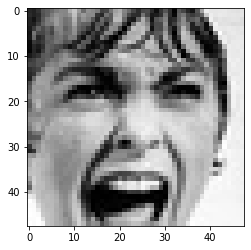

In [33]:
#Pick a random image from the RandomImages folder, containing all test images from FER2013, not from CSV data.
test_image_count = len(os.listdir('/com.docker.devenvironments.code/fer2013/RandomImages'))
print('There are ' + str(test_image_count) + ' images in the testing folder')

test_image = random.choice(os.listdir('/com.docker.devenvironments.code/fer2013/RandomImages'))
img_path = ('/com.docker.devenvironments.code/fer2013/RandomImages/' + test_image)
#Load the selected image
img = image.load_img(img_path, grayscale=True, target_size=(48,48,1))

#Translate image into array form so it can be fed into the prediction function.
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

prediction = np.argmax(model.predict(x))

#Display the image and the predicted emotion as an output.
print('The predicted emotion is : ' + label_dict[prediction])
my_image = image.load_img(img_path)
plt.imshow(my_image)



In [34]:
#Load the saved model.
model = load_model('Original Model')

In [35]:
#Evaluate on Test Data, quickly runs a batch of data through the model to test accuracy and loss:
results = model.evaluate(X_test, y_test, batch_size = 256)
print("test loss, test acc",results)

25/25 [==============================] - 6s 216ms/step - loss: 0.8940 - accuracy: 0.8185
test loss, test acc [0.8940480947494507, 0.8185285329818726]


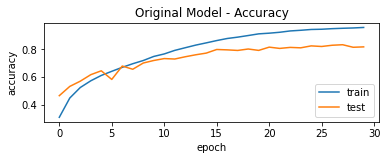

In [36]:
#Plot graphs for accuracy and loss, can ONLY be done in the same execution as training since Model_Result doesnt save.
#plt.subplot(2,1,1)
#plt.plot(Model_Results.history['accuracy'])
#plt.plot(Model_Results.history['val_accuracy'])
#plt.title('Original Model - Accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc = 'lower right')

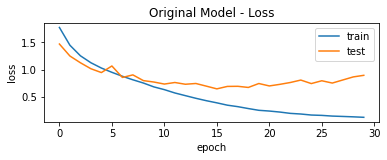

In [37]:
#plt.subplot(2,1,2)
#plt.plot(Model_Results.history['loss'])
#plt.plot(Model_Results.history['val_loss'])
#plt.title('Original Model - Loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc = 'upper right')
